# Human Presence Sensing

### Importing the necessary Libraries 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score

import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

C:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### Reading and Exploring the Data

In [2]:
# Reading the data into a Pandas Data-Frame
data = pd.read_csv('sample_data.txt',sep=",")

In [3]:
# Function to clean the data
def clean_data(data):
    """
    Function to clean the dataset by:
    -removing whitespaces and special characters 
    -fixing data-types
    -converting Stream, Overall, and Truth data to '0' or '1' values
    -setting 'Timestamp' as the index for the dataset
    
    Arguments:
    data: The dataset read as a pandas dataframe
    
    Returns:
    data: The cleaned-data in the form of a pandas dataframe
    """
    # Removing whitespaces from column-names
    data = data.rename(columns=lambda x: x.strip())
    
    # Removing whitespaces from the data in each column
    data['Stream1']=data['Stream1'].map(lambda x: x.strip())
    data['Stream2']=data['Stream2'].map(lambda x: x.strip())
    data['Stream3']=data['Stream3'].map(lambda x: x.strip())
    data['Stream4']=data['Stream4'].map(lambda x: x.strip())
    data['Overall']=data['Overall'].map(lambda x: x.strip())
    data['Truth']=data['Truth'].map(lambda x: x.strip())
    
    # Removing the special characters from the Timestamp and fixing the data-type
    data['Timestamp']=data['Timestamp'].map(lambda x: x.strip('[]'))
    data['Timestamp'] = pd.to_datetime(data['Timestamp'], infer_datetime_format=True)
    
    # Converting the Stream, Overall, and Truth data to boolean values
    d = {'True': True, 'False': False}
    data['Stream1']= data['Stream1'].map(d)
    data['Stream2']=data['Stream2'].map(d)
    data['Stream3']=data['Stream3'].map(d)
    data['Stream4']=data['Stream4'].map(d)
    data['Overall']=data['Overall'].map(d)
    data['Truth']=data['Truth'].map(d)
    
    # Converting the Stream, Overall, and Truth data to '0' or '1' values for ease of analysis
    data['Stream1']=data['Stream1'].astype('int')
    data['Stream2']=data['Stream2'].astype('int')
    data['Stream3']=data['Stream3'].astype('int')
    data['Stream4']=data['Stream4'].astype('int')
    data['Overall']=data['Overall'].astype('int')
    data['Truth']=data['Truth'].astype('int')
    
    # Setting the Timestamp as the index for the dataset
    data.set_index('Timestamp',inplace=True)
    
    # Returning the cleaned data
    return(data)

# Function for initial data exploration
def data_explore_1(data):
    """
    Function to explore the dataset before cleaning by viewing:
    -a sample of the dataset
    -the number of null-values in the dataset
    -column details
    -unique classes in each column
    
    Arguments:
    data: The dataset read as a pandas dataframe
    """
    print("This dataset has "+str(len(data.index))+" rows and "+str(len(data.columns))+" columns.")
    print('\n\n')
    print("First few observations in the dataset: \n\n"+ str(data.head()))
    print('\n\n')
    print("Number of Null-values in each column: \n\n"+ str(data.isna().sum()))
    print('\n\n')
    print("Information regarding the columns in the dataset: \n")
    print(data.info())
    print('\n\n')
    print("Unique values in each column in the dataset:\n")
    for col in data.columns:
        print("Unique values in "+col+": "+str(data[col].unique()))
    
# Function for data exploration post cleaning
def data_explore_2(data):
    """
    Function to explore the dataset after cleaning by viewing:
    -a sample of the dataset
    -column details
    -unique classes in each column
    -correlation between the features
    -accuracy of the black box non-ML algorithm
    -spacing between the observations
    
    Arguments:
    data: The dataset read as a pandas dataframe
    """
    print("First few observations in the dataset: \n\n"+ str(data.head()))
    print('\n\n')
    print("Information regarding the columns in the dataset: \n")
    print(data.info())
    print('\n\n')
    print("Unique values in each column in the dataset:\n")
    for col in data.columns:
        print("Unique values in "+col+": "+str(data[col].unique()))
        print("Value Counts:")
        print(data[col].value_counts())
        print('\n')
    print('\n\n')
    print("Checking for correlation between the variables:\n")
    print(data.corr())
    print('\n\n')
    print("The accuracy of the black box non-ML algorithm = " + str(sum(data['Overall']==data['Truth'])/data.shape[0]))
       
    # Studying the spacing between the observations and its frequency
    Time_Diff = [(data.index[i+1] - data.index[i]).total_seconds() for i in range(len(data.index)-1)]
    unique_difference = set(Time_Diff)
    print('\n\n')
    print("The spacing between the observations in terms of sampling time and the frequency of each difference:\n")
    print([(i,Time_Diff.count(i)) for i in unique_difference])
    

In [4]:
# Exploratory analysis on the data
data_explore_1(data)

This dataset has 8241 rows and 7 columns.



First few observations in the dataset: 

                   Timestamp  Stream1  Stream2  Stream3  Stream4  Overall  \
0  [2016-07-05 20:01:32.470]    False    False    False    False    False   
1  [2016-07-05 20:01:32.580]    False    False    False    False    False   
2  [2016-07-05 20:01:32.727]    False    False    False    False    False   
3  [2016-07-05 20:01:32.837]    False    False    False    False    False   
4  [2016-07-05 20:01:32.947]    False    False    False    False    False   

    Truth  
0   False  
1   False  
2   False  
3   False  
4   False  



Number of Null-values in each column: 

Timestamp    0
 Stream1     0
 Stream2     0
 Stream3     0
 Stream4     0
 Overall     0
 Truth       0
dtype: int64



Information regarding the columns in the dataset: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8241 entries, 0 to 8240
Data columns (total 7 columns):
Timestamp    8241 non-null object
 Stream1     8241 non-n

##### It is apparent that there are whitespaces, special characters, and datatypes in the dataset that need to be fixed. Additionally, the TimeStamp isn't equally spaced (varying sampling rate). 

In [5]:
# Cleaning the data
data = clean_data(data)

In [6]:
# Data exploration post-cleaning
data_explore_2(data)

First few observations in the dataset: 

                         Stream1  Stream2  Stream3  Stream4  Overall  Truth
Timestamp                                                                  
2016-07-05 20:01:32.470        0        0        0        0        0      0
2016-07-05 20:01:32.580        0        0        0        0        0      0
2016-07-05 20:01:32.727        0        0        0        0        0      0
2016-07-05 20:01:32.837        0        0        0        0        0      0
2016-07-05 20:01:32.947        0        0        0        0        0      0



Information regarding the columns in the dataset: 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8241 entries, 2016-07-05 20:01:32.470000 to 2016-07-05 20:18:21.356000
Data columns (total 6 columns):
Stream1    8241 non-null int32
Stream2    8241 non-null int32
Stream3    8241 non-null int32
Stream4    8241 non-null int32
Overall    8241 non-null int32
Truth      8241 non-null int32
dtypes: int32(6)
memory usage:

#### It is evident that the classes are quite imbalenced. [Around 73% of the observations belong to when humans were present in the room]. Additionally, there is significant correlation (0.74) between 'Truth' and 'Overall', which is quite expected. We can also see that there aren't any duplicated features.

#### Another challege that is evident from the EDA is the unequal spacing between the observations. This should be taken care of since most Machine Learning models assume that the data fed into it is an equally spaced Time-series.

In [7]:
# Finding the number of non-constant and non-quasi-constant features
sel = VarianceThreshold(threshold=0.01)  # 0.1 indicates 99% of observations approximately
 
sel.fit(data)  # fit finds the features with low variance
 
sum(sel.get_support())

5

#### Only one feature, Stream3, is constant. The rest of the features provide significant information on the Truth varaible. This might be because of the following reasons: (1)Sensor at Node-3 is not operational; (2) The ON-Threshold value used by the Black Box Stream Algorithm to analyze Raw-Stream-3 is too high and hence it is unable to detect human presence; (3) There is some object (maybe made up of aluminum foil, and other electrically conductive metals) interfering with the RF signals; (4) The sensor is positioned in an inaccessible part of the room (which is possibly very large);

### Visualizing the Data

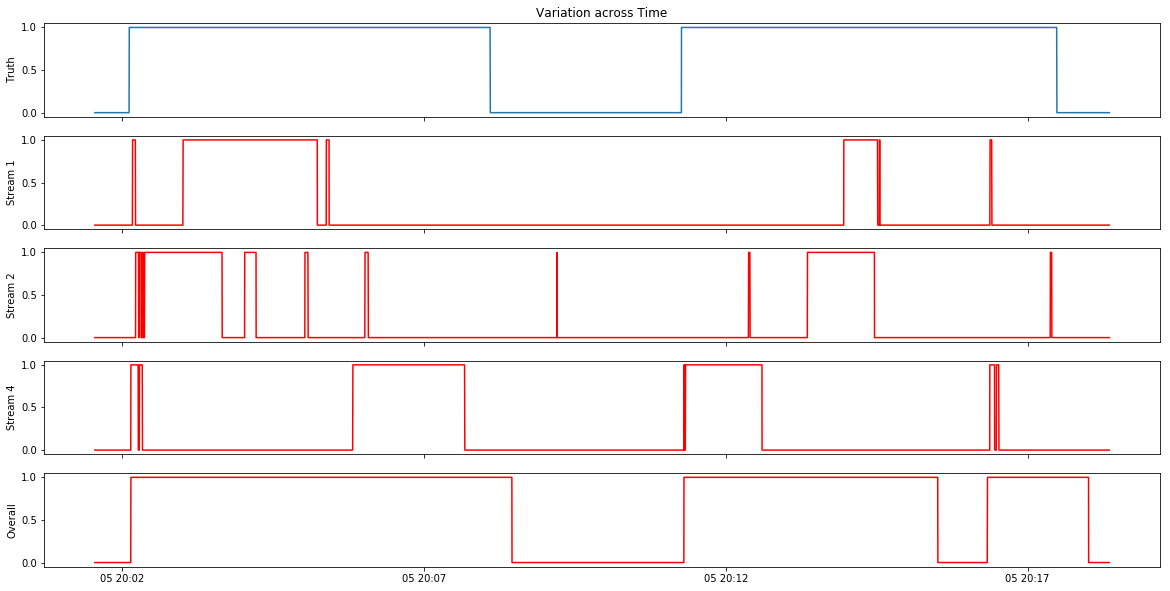

In [8]:
# Visualizing the movement of the variables across time
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, sharex=True, sharey=True,figsize=(20,10))
ax1.plot(data.index, data['Truth'])
ax1.set_title('Variation across Time')
ax2.plot(data.index, data['Stream1'], color='r')
ax3.plot(data.index, data['Stream2'], color='r')
ax4.plot(data.index, data['Stream4'], color='r')
ax5.plot(data.index, data['Overall'], color='r')
ax1.set_ylabel('Truth')
ax2.set_ylabel('Stream 1')
ax3.set_ylabel('Stream 2')
ax4.set_ylabel('Stream 4')
ax5.set_ylabel('Overall')
plt.show()

##### The spike in Stream 2 at '2016-07-05 20:09:12.048' looks like a disturbance rather than the presence of a human. It lasted only for a few milli-seconds and it was observed when there wasn't any human present in the room.

##### It seems like the Black Box non-ML algorithm predicts the presence of a human if any one of the data streams detects the presence. Additionally, if Stream-1 changes its Truth value from 1 to 0 (while the rest of the Streams show '0'), the Black Box algorithm will maintain its Truth value as '1' for an additional 58 seconds approximately. Similarly for Stream-2 it persists for an additional 37 seconds and for Stream-4 it is 47 seconds approximately.

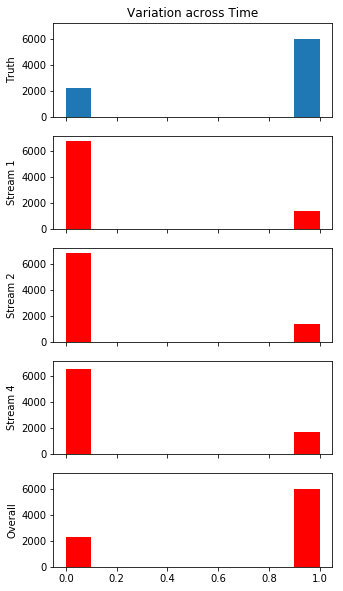

In [9]:
# Visualizing the distribution of classes across variables
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, sharex=True, sharey=True,figsize=(5,10))
ax1.hist(data['Truth'])
ax1.set_title('Variation across Time')
ax2.hist(data['Stream1'], color='r')
ax3.hist(data['Stream2'], color='r')
ax4.hist(data['Stream4'], color='r')
ax5.hist(data['Overall'], color='r')
ax1.set_ylabel('Truth')
ax2.set_ylabel('Stream 1')
ax3.set_ylabel('Stream 2')
ax4.set_ylabel('Stream 4')
ax5.set_ylabel('Overall')
plt.show()

Text(0,0.5,'Number of Predictions')

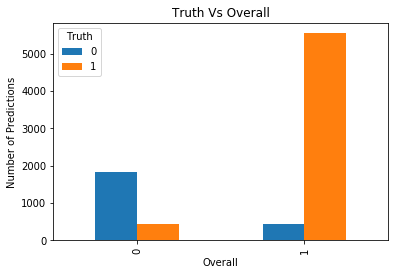

In [10]:
# Visualizing the prediction of the Black Box non-ML Algorithm
pd.crosstab(data.Overall,data.Truth).plot(kind='bar')
plt.title('Truth Vs Overall')
plt.xlabel('Overall')
plt.ylabel('Number of Predictions')

In [11]:
# Studying the frequency of various states of the Stream data
data_grouped = data.groupby(['Stream1','Stream2','Stream3','Stream4'])
grp_count = data_grouped[['Truth']].count()
grp_count.rename(columns={'Truth':'Count'},inplace=True)
display(grp_count)

Count
Stream1 Stream2 Stream3 Stream4       
0       0       0       0         4535
                        1         1568
        1       0       0          633
                        1           74
1       0       0       0          725
                        1           39
        1       0       0          667

#### It is evident that the features are highly sparse.

### Converting the Data to an Evenly-Spaced Time Series

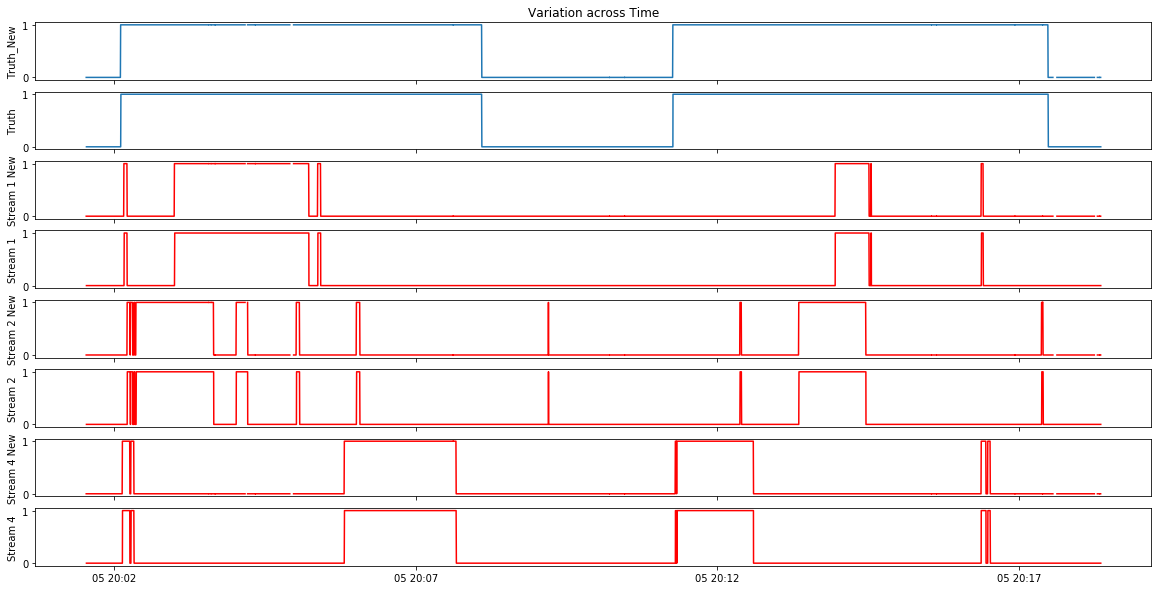

In [12]:
# Comparing the Original-Data with data downsampled with a frequency of 250 milli-seconds (using max() for aggregation)
data_resampled_max = data.resample('0.25S').max()
f, (ax1, ax2, ax3, ax4, ax5,ax6,ax7,ax8) = plt.subplots(8, sharex=True, sharey=True,figsize=(20,10))
ax1.plot(data_resampled_max.index, data_resampled_max['Truth'])
ax1.set_title('Variation across Time')
ax2.plot(data.index, data['Truth'])
ax3.plot(data_resampled_max.index, data_resampled_max['Stream1'], color='r')
ax4.plot(data.index, data['Stream1'], color='r')
ax5.plot(data_resampled_max.index, data_resampled_max['Stream2'], color='r')
ax6.plot(data.index, data['Stream2'], color='r')
ax7.plot(data_resampled_max.index, data_resampled_max['Stream4'], color='r')
ax8.plot(data.index, data['Stream4'], color='r')


ax1.set_ylabel('Truth_New')
ax2.set_ylabel('Truth')
ax3.set_ylabel('Stream 1 New')
ax4.set_ylabel('Stream 1')
ax5.set_ylabel('Stream 2 New')
ax6.set_ylabel('Stream 2')
ax7.set_ylabel('Stream 4 New')
ax8.set_ylabel('Stream 4')

plt.show()

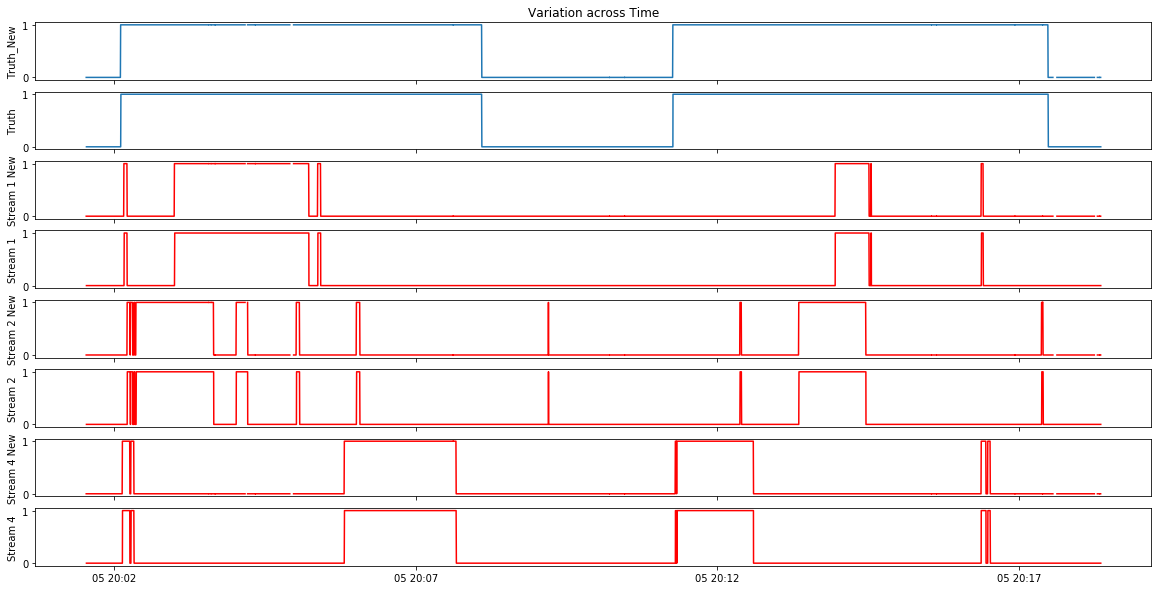

In [13]:
# Comparing the Original-Data with data downsampled with a frequency of 250 milli-seconds (using last() for aggregation)
data_resampled_last = data.resample('0.25S').last()
f, (ax1, ax2, ax3, ax4, ax5,ax6,ax7,ax8) = plt.subplots(8, sharex=True, sharey=True,figsize=(20,10))
ax1.plot(data_resampled_max.index, data_resampled_max['Truth'])
ax1.set_title('Variation across Time')
ax2.plot(data.index, data['Truth'])
ax3.plot(data_resampled_max.index, data_resampled_max['Stream1'], color='r')
ax4.plot(data.index, data['Stream1'], color='r')
ax5.plot(data_resampled_max.index, data_resampled_max['Stream2'], color='r')
ax6.plot(data.index, data['Stream2'], color='r')
ax7.plot(data_resampled_max.index, data_resampled_max['Stream4'], color='r')
ax8.plot(data.index, data['Stream4'], color='r')


ax1.set_ylabel('Truth_New')
ax2.set_ylabel('Truth')
ax3.set_ylabel('Stream 1 New')
ax4.set_ylabel('Stream 1')
ax5.set_ylabel('Stream 2 New')
ax6.set_ylabel('Stream 2')
ax7.set_ylabel('Stream 4 New')
ax8.set_ylabel('Stream 4')

plt.show()

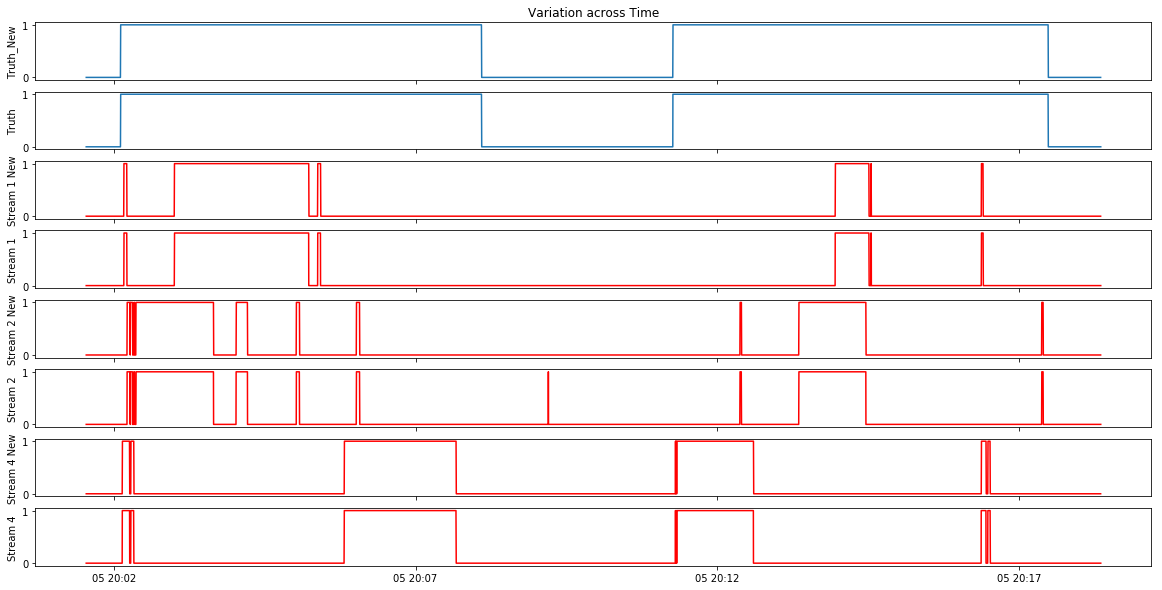

In [14]:
# Comparing the Original-Data with data resampled using a two-step process
# Step_1: upsample the data with a frequency of 1 milli-seconds (using the last as aggregation function and linear interpolation)
# Step_2: downsample the data to the desired goal frequency using a forward fill aggregation
temp = data.resample('ms').ffill().interpolate()
data_resampled_twostep = temp.resample('0.25S').ffill()
f, (ax1, ax2, ax3, ax4, ax5,ax6,ax7,ax8) = plt.subplots(8, sharex=True, sharey=True,figsize=(20,10))
ax1.plot(data_resampled_twostep.index, data_resampled_twostep['Truth'])
ax1.set_title('Variation across Time')
ax2.plot(data.index, data['Truth'])
ax3.plot(data_resampled_twostep.index, data_resampled_twostep['Stream1'], color='r')
ax4.plot(data.index, data['Stream1'], color='r')
ax5.plot(data_resampled_twostep.index, data_resampled_twostep['Stream2'], color='r')
ax6.plot(data.index, data['Stream2'], color='r')
ax7.plot(data_resampled_twostep.index, data_resampled_twostep['Stream4'], color='r')
ax8.plot(data.index, data['Stream4'], color='r')


ax1.set_ylabel('Truth_New')
ax2.set_ylabel('Truth')
ax3.set_ylabel('Stream 1 New')
ax4.set_ylabel('Stream 1')
ax5.set_ylabel('Stream 2 New')
ax6.set_ylabel('Stream 2')
ax7.set_ylabel('Stream 4 New')
ax8.set_ylabel('Stream 4')

plt.show()

##### The two-step resampled series is more smooth, retains the original structure of the series, and removes the spike in Stream 2 at '2016-07-05 20:09:12.048'. Hence, I'm moving forward with the two-step resampled data.

In [15]:
# Extracting the two-step resampled series into a new dataframe and removing the first datapoint (Since it had null values for all features)
temp = data.resample('ms').ffill().interpolate()
TS_Data = temp.resample('0.25S').ffill()[1:]
TS_Data.head()

,Stream1,Stream2,Stream3,Stream4,Overall,Truth
Timestamp,,,,,,
2016-07-05 20:01:32.500,0.0,0.0,0.0,0.0,0.0,0.0
2016-07-05 20:01:32.750,0.0,0.0,0.0,0.0,0.0,0.0
2016-07-05 20:01:33.000,0.0,0.0,0.0,0.0,0.0,0.0
2016-07-05 20:01:33.250,0.0,0.0,0.0,0.0,0.0,0.0
2016-07-05 20:01:33.500,0.0,0.0,0.0,0.0,0.0,0.0


### Feature Engineering

In [16]:
# Function for Adding lags to the features
def add_lags(data, n_in=1, dropnan=True):
    """
    Creates new dataframe that includes lags for each of the features
    Arguments:
      data: Original DataFrame with the features that require lags
      n_in: Number of lag observations 
      dropnan: Boolean whether or not to drop rows with NaN values
    Returns:
      Pandas DataFrame with features along with their lagged versions
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (j, i)) for j in df.columns]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    agg_final = pd.concat([data,agg], axis=1)
    # drop rows with NaN values
    if dropnan:
        agg_final.dropna(inplace=True)
    return agg_final

In [17]:
# Calling the function for Adding lags to the features
data_ARDL = add_lags(TS_Data.drop(['Overall','Stream3'],axis=1), n_in=4,dropnan=True)

In [18]:
# Adding Rolling Window Statistics to the data
window = TS_Data.drop(['Overall','Stream3'],axis=1).rolling(window=20)
maximum_vals = window.sum()
maximum_vals.columns = ['Stream1_roll', 'Stream2_roll', 'Stream4_roll', 'Truth_roll']
maximum_vals.dropna(inplace=True)

# Merging the Rolling window statistic with the Distributed-lag data
data_final = pd.concat([data_ARDL,maximum_vals],axis=1)
data_final.dropna(inplace=True)

In [19]:
# Extracting the Target variable from the data
y = data_final[['Truth']]

# Extracting the relevant features after removing the Traget and constant-feature
X = data_final.drop('Truth',axis=1)

In [20]:
# Checking for duplicated features after feature engineering
duplicated_feat = []
for i in range(0, len(X.columns)): 
    col_1 = X.columns[i]
 
    for col_2 in X.columns[i + 1:]:
        if X[col_1].equals(X[col_2]):
            duplicated_feat.append(col_2)
            
len(duplicated_feat)

0

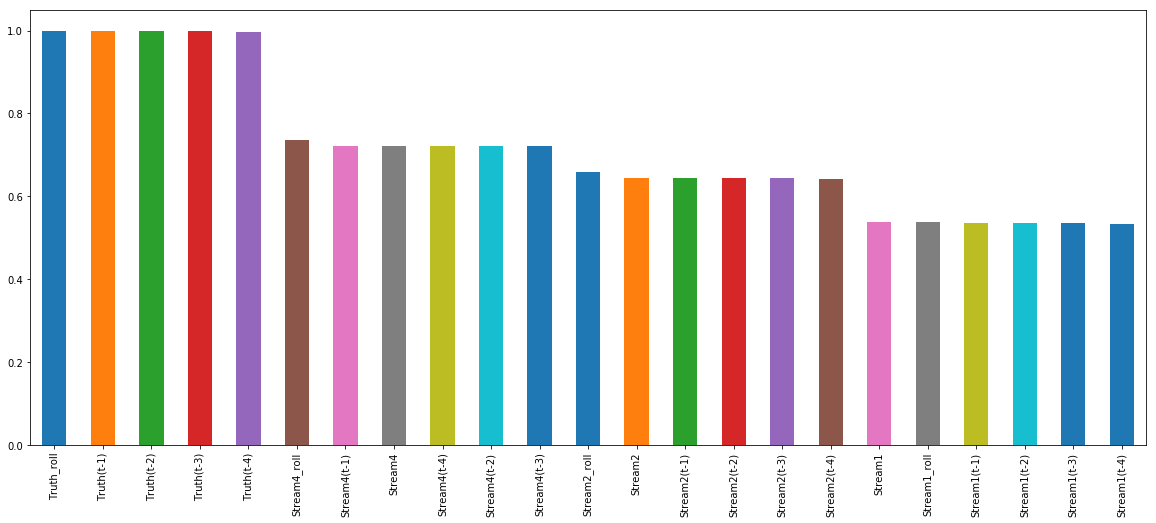

In [21]:
# find important features using univariate roc-auc
 
# loop to build a tree, make predictions and get the roc-auc
# for each feature of the train set
X_train = X[0:2008]
y_train =y[0:2008]
X_test = X[2009:3012]
y_test = y[2009:3012]
roc_values = []
for feature in X_train.columns:
    clf = DecisionTreeClassifier()
    clf.fit(X_train[feature].fillna(0).to_frame(), y_train)
    y_scored = clf.predict_proba(X_test[feature].fillna(0).to_frame())
    roc_values.append(roc_auc_score(y_test, y_scored[:, 1]))
    
# let's add the variable names and order it for clearer visualisation
roc_values = pd.Series(roc_values)
roc_values.index = X_train.columns
roc_values.sort_values(ascending=False).plot.bar(figsize=(20, 8))

In [22]:
roc_values[roc_values<=0.6]

Stream1         0.536585
Stream1(t-4)    0.533716
Stream1(t-3)    0.534433
Stream1(t-2)    0.535151
Stream1(t-1)    0.535868
Stream1_roll    0.536585
dtype: float64

#### The predictive capacity of Data from Stream-1, along with its lags and rolling statistic, is quite low according to the univariate roc-auc. We will keep an eye on these features as we go through the analysis.

### Modeling

In [23]:
# Baseline model: Predict every value as 1
print("Accuracy of the Baseline model: " + str(len(data[data['Truth']==1].index)/len(data.index)))

Accuracy of the Baseline model: 0.7255187477247906


In [24]:
# Function for Time-Series Cross validation
def TS_CrossVal(num_splits, X, y, classifier):
    """
    Prints out the Mean accuracy score and the mean AUC score for the given classifier after Time-series crossvalidation
    Arguments:
      num_splits: Number of splits to be used by the TimeSeriesSplit crossvalidation object
      X: Explanatory variables
      y: Dependent variable
      classifier: The classifier object instantiated using the required parameters
    Returns:
      No return value
    """
    # Create time-series cross-validation object
    tscv = TimeSeriesSplit(n_splits=num_splits)
    scores_cv = list()
    auc_scores = list()
    
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X[min(train_index):max(train_index)], X[min(test_index):max(test_index)]
        y_train, y_test = y[min(train_index):max(train_index)], y[min(test_index):max(test_index)]
        clf = classifier.fit(X_train.values, y_train.values.ravel())
        scores_cv.append(clf.score(X_test,y_test))
        y_scores_clf = clf.decision_function(X_test.values)
        fpr_clf, tpr_clf, _ = roc_curve(y_test.values, y_scores_clf)
        roc_auc_clf = auc(fpr_clf, tpr_clf)
        auc_scores.append(roc_auc_clf)
    
    print("The mean score of the Classifier is: " + str(np.mean(scores_cv))) 
    print("The mean Area under the ROC curve of the classifier is: " + str(np.nanmean(auc_scores)))

In [25]:
# Function for building an ROC curve
def plot_roc(clf,y_test,X_test,y_train,X_train):
    """
    Building and plotting the ROC curve for Classification algorithms
    Arguments:
      clf: Instance of the Classifier
      y_test: Test set of the dependent variable
      X_test: Test set of the independent variables
      y_train: Training set of the dependent variable
      X_train: Training set of the independent variables
    Returns:
      No return value
    """
    clf_roc_auc = roc_auc_score(y_test, clf.predict(X_test))
    fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label='Classifier (area = %0.2f)' % clf_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

### Logistic Regression

In [26]:
# Logistic Regression
sm_model = sm.Logit(y.values.ravel(), sm.add_constant(X.values)).fit(disp=0,method='bfgs',maxiter=100)
var_names = list()
var_names.append('const')
for i in X.columns:
    var_names.append(i)
sm_model.summary(xname=var_names)

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 4017
Model:                          Logit   Df Residuals:                     3993
Method:                           MLE   Df Model:                           23
Date:                Sun, 07 Apr 2019   Pseudo R-squ.:                  0.9878
Time:                        16:11:58   Log-Likelihood:                -28.622
converged:                       True   LL-Null:                       -2346.3
                                        LLR p-value:                     0.000
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -6.3760      0.727     -8.766      0.000      -7.801      -4.950
Stream1          0.0818     37.328      0.002      0.998     -73.081      73.244
Stream2          0.1406     28.880      0.005      0.996     -56.463      56.745
Stream4          0.2950     13.826      0.021      0.983     -26.804      27.393
Stream1(t-4)     0.0228    407.481    5.6e-05      1.000    -798.625     798.671
Stream2(t-4)     0.0351    150.089      0.000      1.000    -294.134     294.205
Stream4(t-4)     0.0230     57.634      0.000      1.000    -112.938     112.984
Truth(t-4)      -3.2870     18.385     -0.179      0.858     -39.320      32.746
Stream1(t-3)     0.0270    266.100      0.000      1.000    -521.519     521.573
Stream2(t-3)     0.0433    127.328      0.000      1.000    -249.516     249.602
Stream4(t-3)     0.0294     43.368      0.001      0.999     -84.969      85.028
Truth(t-3)      -2.1160     52.016     -0.041      0.968    -104.064      99.833
Stream1(t-2)     0.0350    148.217      0.000      1.000    -290.465     290.535
Stream2(t-2)     0.0590     82.134      0.001      0.999    -160.921     161.040
Stream4(t-2)     0.0532     29.875      0.002      0.999     -58.500      58.607
Truth(t-2)      -0.8226     83.800     -0.010      0.992    -165.068     163.423
Stream1(t-1)     0.0501     79.901      0.001      0.999    -156.552     156.652
Stream2(t-1)     0.0881     52.102      0.002      0.999    -102.030     102.206
Stream4(t-1)     0.1292     17.844      0.007      0.994     -34.845      35.103
Truth(t-1)      15.8389     68.190      0.232      0.816    -117.810     149.488
Stream1_roll     1.1250      8.690      0.129      0.897     -15.907      18.157
Stream2_roll     0.8926     10.941      0.082      0.935     -20.552      22.337
Stream4_roll     0.9100      7.871      0.116      0.908     -14.517      16.337
Truth_roll       0.1499      0.150      1.000      0.317      -0.144       0.444
================================================================================

Possibly complete quasi-separation: A fraction 0.48 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

#### Even though the features show low statistical significance, the model is able to predict the behaviour of the dependent variable with high accuracy (probably due to quasicomplete separation caused by Truth(t-1); this notebook does not rectify this problem).

In [27]:
# Instantiating the LogisticRegression class with 'sag' solver and max_iter=5000
clf = LogisticRegression(random_state=0, solver='sag',max_iter=5000)

# Instantiating the TimeSeriesSplit class
time_split = TimeSeriesSplit(n_splits=3)

# Using grid-search to find the best value for regularization parameter
c_values = np.logspace(-2, 2, 10)
logit_grid_searcher = GridSearchCV(estimator=clf, param_grid={'C': c_values}, scoring='roc_auc', n_jobs=1, cv=time_split, verbose=1)
logit_grid_searcher.fit(X, y)
logit_grid_searcher.best_score_, logit_grid_searcher.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   21.4s finished


(1.0, {'C': 0.01})

In [28]:
# Instantiating the LogisticRegression class with updated parameters 
clf_updated = LogisticRegression(random_state=0, solver='sag',max_iter=5000,C=0.01)

In [29]:
# Checking the performance of the Classifier using Time Series Cross validation
TS_CrossVal(10,X,y,clf_updated)

The mean score of the Classifier is: 0.9909340659340659
The mean Area under the ROC curve of the classifier is: 1.0


In [30]:
# Exploring the importance of each variable solely based on the value of the coefficients (Not based on statistical significance test)
Coef_Importance = [(i,j) for i,j in zip(X.columns.tolist(),clf_updated.coef_[0])]
sorted(Coef_Importance, key=lambda x: x[1],reverse=True)

[('Truth_roll', 0.45730437098546395),
 ('Truth(t-1)', 0.1764050804017458),
 ('Truth(t-2)', 0.14728354182587874),
 ('Stream4_roll', 0.12018980131550737),
 ('Truth(t-3)', 0.11884797244602961),
 ('Truth(t-4)', 0.09150950339824399),
 ('Stream1_roll', 0.08324339735730314),
 ('Stream2_roll', 0.07802590662762375),
 ('Stream4', 0.021846956477247804),
 ('Stream4(t-1)', 0.015440717402529535),
 ('Stream4(t-2)', 0.01085032355253856),
 ('Stream4(t-3)', 0.007832546553653882),
 ('Stream4(t-4)', 0.005994559278972701),
 ('Stream1', 0.004631135575606907),
 ('Stream1(t-1)', 0.00430093372035791),
 ('Stream2', 0.004219543394739278),
 ('Stream2(t-1)', 0.0041590977585519865),
 ('Stream1(t-2)', 0.0041159828101169),
 ('Stream2(t-2)', 0.0041041137988522105),
 ('Stream2(t-3)', 0.004054021953428711),
 ('Stream1(t-3)', 0.004012281000072222),
 ('Stream2(t-4)', 0.004008580452951548),
 ('Stream1(t-4)', 0.0039554912889101)]

#### Even from the Coefficients of the Logistic Regression model it is evident that the predictive capacity of Data from Stream-1, along with its lags and rolling statistic, is quite low

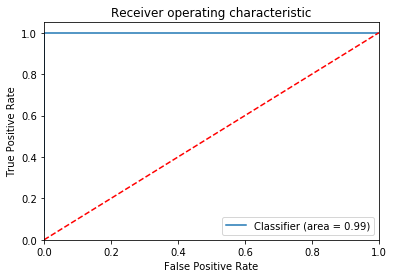

In [31]:
# Splitting the data into Train and Test in order to visualize the ROC curve
X_train = X[0:2008]
y_train =y[0:2008]
X_test = X[2009:3012]
y_test = y[2009:3012]

# Calling the function for building an ROC curve
plot_roc(clf_updated,y_test,X_test,y_train,X_train)

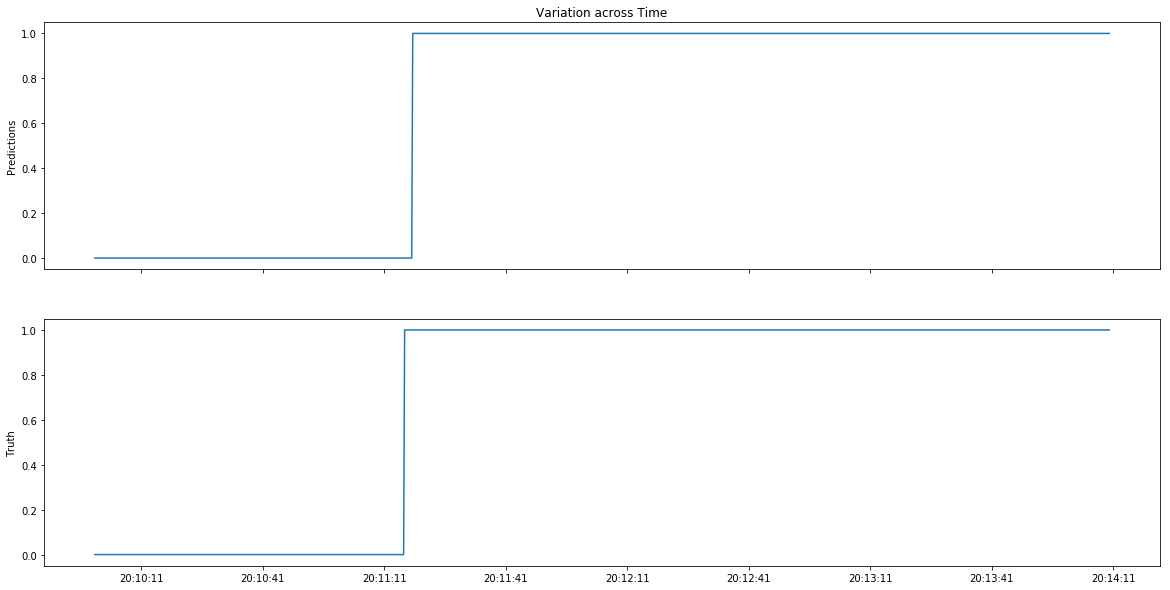

In [52]:
# Making predictions using the updated Logistic Regression Model
predictions_logit = clf_updated.predict(X_test)

# Plotting the predictions vs the 'Truth'
f, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=True,figsize=(20,10))
ax1.plot(X_test.index, predictions_logit)
ax1.set_title('Variation across Time')
ax2.plot(X_test.index, y_test)
ax1.set_ylabel('Predictions')
ax2.set_ylabel('Truth')
plt.show()

In [58]:
# Studying the data-points on which the algorithm was inaccurate in its prediction
X_test.loc[y_test[y_test.Truth!=predictions_logit].index]

,Stream1,Stream2,Stream4,Stream1(t-4),Stream2(t-4),Stream4(t-4),Truth(t-4),Stream1(t-3),Stream2(t-3),Stream4(t-3),...,Stream4(t-2),Truth(t-2),Stream1(t-1),Stream2(t-1),Stream4(t-1),Truth(t-1),Stream1_roll,Stream2_roll,Stream4_roll,Truth_roll
Timestamp,,,,,,,,,,,,,,,,,,,,,
2016-07-05 20:11:16.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2016-07-05 20:11:16.250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0
2016-07-05 20:11:16.500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0
2016-07-05 20:11:16.750,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0
2016-07-05 20:11:17.000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5.0
2016-07-05 20:11:17.250,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6.0
2016-07-05 20:11:17.500,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,7.0
2016-07-05 20:11:17.750,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,8.0


#### The Logistic Regression model misclassified 8 data-points. These data-points lie close to the time when there was a transition in the state of 'Truth'. Will can fine-tune it by adjusting the rolling-window statistics.

### Gradient Boosting Classifier

In [34]:
# Instantiating the GradientBoostingClassifier class
gb = GradientBoostingClassifier(n_estimators=20, learning_rate = 1, max_features=2, max_depth = 2, random_state = 0)

# Instantiating the TimeSeriesSplit class
time_split = TimeSeriesSplit(n_splits=3)

# Using grid-search to find the best value for the parameters
n_estimators = [5,10,15,20]
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
max_features= [2,4,6,8,10]
max_depth= [2,4,6,8,10]
gb_grid_searcher = GridSearchCV(estimator=gb, param_grid={'n_estimators':n_estimators,'learning_rate': learning_rates, 
                                                          'max_features':max_features,'max_depth':max_depth}, 
                                scoring='roc_auc', n_jobs=1, cv=time_split, verbose=1)
gb_grid_searcher.fit(X, y)
gb_grid_searcher.best_score_, gb_grid_searcher.best_params_

Fitting 3 folds for each of 600 candidates, totalling 1800 fits


[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed:   32.3s finished


(0.9999292753391114,
 {'learning_rate': 0.5, 'max_depth': 4, 'max_features': 2, 'n_estimators': 20})

##### Since the performance is quite high, I'm not going to tweak the parameters more.

In [35]:
# Instantiating the GradientBoostingClassifier class with updated parameters 
gb_updated = GradientBoostingClassifier(n_estimators=20, learning_rate = 0.5, max_features=2, max_depth = 4, random_state = 0)

# Checking the performance of the Classifier using Time Series Cross validation
TS_CrossVal(10,X,y,gb_updated)

The mean score of the Classifier is: 0.9942307692307694
The mean Area under the ROC curve of the classifier is: 0.9993206521739131


In [36]:
# Exploring the importance of each variable solely based on the value of the coefficients (Not based on statistical significance test)
Coef_Importance = [(i,j) for i,j in zip(X.columns.tolist(),gb_updated.feature_importances_)]
sorted(Coef_Importance, key=lambda x: x[1],reverse=True)

[('Truth_roll', 0.5088943990929876),
 ('Truth(t-2)', 0.1088740857432013),
 ('Truth(t-1)', 0.09576290729178315),
 ('Truth(t-4)', 0.07331378337842683),
 ('Truth(t-3)', 0.06534620015859141),
 ('Stream1_roll', 0.020999561019677686),
 ('Stream2(t-2)', 0.018953103926796895),
 ('Stream2(t-1)', 0.017981328355848127),
 ('Stream4(t-4)', 0.016632740593837046),
 ('Stream1', 0.01587848017693646),
 ('Stream4(t-1)', 0.013042060808858063),
 ('Stream4(t-3)', 0.01184300616469858),
 ('Stream1(t-4)', 0.01155245219834341),
 ('Stream4(t-2)', 0.004893296109778323),
 ('Stream4', 0.003425302946861594),
 ('Stream1(t-3)', 0.0033969655628839543),
 ('Stream1(t-1)', 0.0030122764674376285),
 ('Stream2(t-3)', 0.0026833695201405024),
 ('Stream4_roll', 0.0016037264259821191),
 ('Stream2_roll', 0.0012133180395265946),
 ('Stream2', 0.00046346961658144204),
 ('Stream1(t-2)', 0.00023415015964234847),
 ('Stream2(t-4)', 1.624117883311984e-08)]

#### The feature importance calculated by the GradientBoostingClassifier model suggests a different story when it comes to the predictive capacity of Data from Stream-1, along with its lags and rolling statistic. Stream1_roll seems to be the 6th most predictive feature.

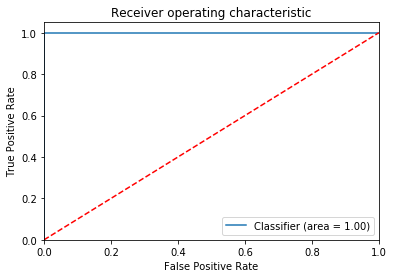

In [37]:
# Calling the function for building an ROC curve
plot_roc(gb_updated,y_test,X_test,y_train,X_train)

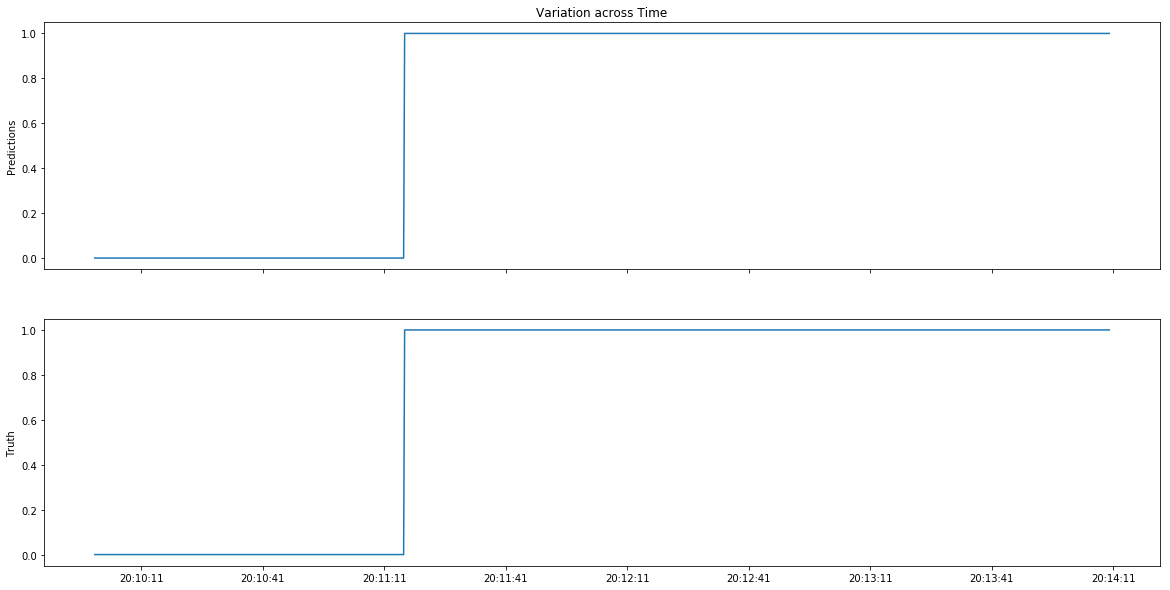

In [59]:
# Making predictions using the updated GradientBoostingClassifier Model
predictions_gb = gb_updated.predict(X_test)

# Plotting the predictions vs the 'Truth'
f, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=True,figsize=(20,10))
ax1.plot(X_test.index, predictions_gb)
ax1.set_title('Variation across Time')
ax2.plot(X_test.index, y_test)
ax1.set_ylabel('Predictions')
ax2.set_ylabel('Truth')
plt.show()

In [60]:
X_test.loc[y_test[y_test.Truth!=predictions_gb].index]

,Stream1,Stream2,Stream4,Stream1(t-4),Stream2(t-4),Stream4(t-4),Truth(t-4),Stream1(t-3),Stream2(t-3),Stream4(t-3),...,Stream4(t-2),Truth(t-2),Stream1(t-1),Stream2(t-1),Stream4(t-1),Truth(t-1),Stream1_roll,Stream2_roll,Stream4_roll,Truth_roll
Timestamp,,,,,,,,,,,,,,,,,,,,,


## Observations:

#### - Stream 3 gives a constant output of ‘0’. This might be because of the following reasons: (1)Sensor at Node-3 is not operational; (2) The ON-Threshold value used by the Black Box Stream Algorithm to analyze Raw-Stream-3 is too high and hence it is unable to detect human presence; (3) There is some object (maybe made up of aluminum foil, and other electrically conductive metals) interfering with the RF signals; (4) The sensor is positioned in an inaccessible part of the room (which is possibly very large);


#### -The spike in Stream 2 at '2016-07-05 20:09:12.048' looks like a disturbance rather than the presence of a human. It lasted only for a few milli-seconds and it was observed when there wasn't any human present in the room.

#### -It seems like the Black Box non-ML algorithm predicts the presence of a human if any one of the data streams detects the presence. Additionally, if Stream-1 changes its Truth value from 1 to 0 (while the rest of the Streams show '0'), the Black Box algorithm will maintain its Truth value as '1' for an additional 58 seconds approximately. Similarly for Stream-2 it persists for an additional 37 seconds and for Stream-4 it is 47 seconds approximately.

#### -The two-step resampled series is more smooth, retains the original structure of the series, and removes the spike in Stream 2 at '2016-07-05 20:09:12.048'. Hence, the two-step resampling is highly effective.

#### -The predictive capacity of Data from Stream-1, along with its lags and rolling statistic, is quite low according to the univariate roc-auc and the coefficients of the Logistic Regression. But, it is significant in the Gradient Boosting Classifier.

#### -Even though the features show low statistical significance, the Logistic Regression model is able to predict the behavior of the dependent variable with high accuracy (probably due to Quasicomplete separation caused by Truth(t-1).

#### -The Logistic Regression model misclassified 8 data-points. These data-points lie close to the time when there was a transition in the state of 'Truth'. Will can fine-tune it by adjusting the rolling-window statistics.

#### -The GradientBoostingClassifier was able to predict all the values in the test set accurately

#### -Other models (like Markov Switching models, RNNs, etc) were not explored since the performance from the simpler models were impressive 